In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits import mplot3d

In [5]:
#Constants
alpha = 0.01 #gilbert damping constant
mu_0 = 1.25663706212*(10**(-6))
gamma = 1.76085963023*(10**11) #(rad/sT) gyromagnetic ratio of electron
H = [0,0,1]

In [85]:
# Advised constants
alpha = 0.007 #gilbert damping constant
mu_0 = 4*math.pi*(10**(-7)) #(Tm/A)
gamma = 1.76*(10**11) #(rad/sT) gyromagnetic ratio of electron
M_s = 850*10**(3) #(A/m) Saturation magnetization of nanomagnet
I_s = 0.4644 #(A) applied spin current
delta = 42 #thermal stability factor
temp = 300 #(K) temperature
ht = 6.62607015*(10**(-34)) # (J Hz^-1) planck constant from nist
q_e = 1.602176634*(10**(-19)) # (C) elementary charge of electron from nist
k_B = 1.380649*(10**(-23)) # (JK^-1) Boltzmann constant from nist
 

# Dimensions
W = 40 #(nm)
L = 120 #(nm)
t_fl = 1.5 #(nm)
A = (math.pi/4)*L*W # cross sectional area of MTJ
V = A*t_fl

J_mtj = I_s/A # surface current for mtj

H_k = 2*delta*k_B*temp/(V*mu_0*M_s)
demag_const = np.array([-0.066*M_s, -0.911*M_s, -0.022*M_s])
m_p = np.array([0,0,1])

In [86]:
def eq1(x, y): 
    return ((x - y)/2) 

# A sample differential equation "dy/dx = -y" 
def eq2(x, y): 
    return (-y) 

# differential equation for precision term of LLGS" 
def eq3(t, M):
    return -(gamma*mu_0)/(1+alpha**2)*np.cross(M,H)
    
# differential equation for LLGS (based on debasis' note)" 
def llgs(t, m, H_eff):
    beta = (gamma*ht*J_mtj)/(2*q_e*M_s*t_fl) 
    return -(gamma*mu_0)/(1+alpha**2) * np.cross(m,H_eff) \
    - alpha*(gamma*mu_0)/(1+alpha**2) * np.cross(m,np.cross(m,H_eff)) \
    - beta/(1+alpha**2) * np.cross(np.cross(m,m), m_p) \
    + alpha*beta/(1+alpha**2) * np.cross(m,m_p)

# # Finds value of y for a given x using step size h 
# # and initial value y0 at x0. 
def rungeKuttaNew(diff_eq, x_n, y_n, x, h): 
    y = y_n 
    n = int((x - x_n)/h) 
    # Iterate for n number of iterations 
    for i in range(1, n + 1): 
        "Apply Runge Kutta Formulas to find next value of y"
        k1 = h * diff_eq(x_n, y) 
        k2 = h * diff_eq(x_n + 0.5*h, y + 0.5*k1*h) 
        k3 = h * diff_eq(x_n + 0.5*h, y + 0.5*k2*h) 
        k4 = h * diff_eq(x_n + h, y + k3*h) 
        # Update next value of y 
        y = y + (1.0 / 6.0)*(k1 + 2*k2 + 2*k3 + k4) 
        # Update next value of x 
        x_n = x_n + h 
    return y 

def rungeKutta(diff_eq, x_n, y_n, x, h): 
    y = y_n 
    n = int((x - x_n)/h) 
    # Iterate for n number of iterations 
    for i in range(1, n + 1): 
        "Apply Runge Kutta Formulas to find next value of y"
        k1 = h * diff_eq(x_n, y) 
        k2 = h * diff_eq(x_n + 0.5*h, y + 0.5*k1) 
        k3 = h * diff_eq(x_n + 0.5*h, y + 0.5*k2) 
        k4 = h * diff_eq(x_n + h, y + k3) 
        # Update next value of y 
        y = y + (1.0 / 6.0)*(k1 + 2*k2 + 2*k3 + k4) 
        # Update next value of x 
        x_n = x_n + h 
    return y 

def llgsRK(x_n, y_n, x, h, H_eff): 
    y = y_n 
    n = int((x - x_n)/h) 
    # Iterate for n number of iterations 
    for i in range(1, n + 1): 
        "Apply Runge Kutta Formulas to find next value of y"
        k1 = h * llgs(x_n, y, H_eff) 
        k2 = h * llgs(x_n + 0.5*h, y + 0.5*k1, H_eff) 
        k3 = h * llgs(x_n + 0.5*h, y + 0.5*k2, H_eff) 
        k4 = h * llgs(x_n + h, y + k3, H_eff) 
        # Update next value of y 
        y = y + (1.0 / 6.0)*(k1 + 2*k2 + 2*k3 + k4) 
        # Update next value of x 
        x_n = x_n + h 
    return y

# calculate y value of x series
def calcYSeries(diff_eq, x_axis, h, x_0, y_0):
    # RK4 solution
    y_rk4 = []
    y_prev = y_0
    x_prev = x_0
    
    for x in x_axis:
        new_y = rungeKutta(diff_eq, x_prev, y_prev, x, h, H_eff)
        y_rk4.append(new_y)
        y_prev = new_y
        x_prev = x
        H_eff = np.add([0,0,H_k*new_y[2]], demag_const*new_y)
        
    # change all elements to list
    for i in range(1,len(y_rk4)):
        y_rk4[i] = y_rk4[i].tolist()
    return y_rk4

# calculate y value of x series
def calcMSeries(t_axis, h, t_0, m_0):
    # RK4 solution
    m_rk4 = []
    m_prev = m_0
    t_prev = t_0
    
    H_eff = np.add([0,0,H_k*m_0[2]], np.multiply(demag_const, m_0))    
    for t in t_axis:
        new_m = llgsRK(t_prev, m_prev, t, h, H_eff)
        m_rk4.append(new_m)
        m_prev = new_m
        t_prev = t
        H_eff = np.add([0,0,H_k*new_m[2]], np.multiply(demag_const, new_m) )
        
    # change all elements to list
    for i in range(1,len(m_rk4)):
        m_rk4[i] = m_rk4[i].tolist()
    return m_rk4

In [104]:
# # Test 1  
# x0 = 0
# y0 = 1
# x = 2
# h_list = [2, 1, 0.8, 0.5, 0.2, 0.1, 0.001, 10**(-3)]
# print("Using differential equation dy/dx = (x - y)/2")
# for h in h_list:
#     ans = rungeKuttaNew(eq1, x0, y0, x, h)
#     print('when h = {} the value of y at x is:{}'.format(str(h),ans))
#     print('accuracy = {}'.format(((1.605551275-ans)/1.605551275)*100))


In [23]:
# # Test 2  
# x0 = 0
# y0 = 1
# x = 5
# h_list = [2, 1, 0.8, 0.5, 0.2, 0.1 , 10**(-3)]
# print("Using differential equation new dy/dx = -y")
# for h in h_list:
#     ans = rungeKuttaNew(eq2, x0, y0, x, h)
#     print('when h = {} the value of y at x is:{}'.format(str(h),ans))
#     print('accuracy = {}'.format(((0.367879-ans)/0.367879)*100))

### Test with dy/dx=-y

In [24]:
# Test Debasis
x_axis = np.linspace(0,8,100)
y_anal = np.exp(-x_axis)
y_rk4 = []

for x in x_axis:
    y_rk4.append(rungeKuttaNew(eq2, 0, 1, x, 0.08))
    

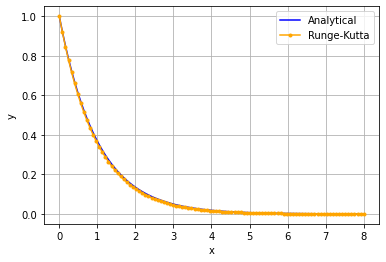

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(x_axis, y_anal, 'b', label='Analytical')
plt.plot(x_axis, y_rk4, 'orange', marker=".", label='Runge-Kutta')

plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper right')
plt.grid()

plt.show()

### Test with precision term of LLGS

In [26]:
t_range = 5*10**(-4)
step_amount = 2001
t_axis = np.linspace(0,t_range,step_amount)

h = t_range/step_amount
m_0 = [0, 1/2, math.sqrt(1-(1/2)**2)]

# #analytical solution
# m_anal = []
# for t in t_axis:
#     m_anal_res = np.exp(-(gamma*mu_0)/(1+alpha**2)*t*H)
#     m_anal.append(m_anal_res)
#     print(m_anal_res)

In [27]:
# RK4 solution
m_rk4 = []
m_prev = m_0
t_prev = 0

for t in t_axis:
    new_m = rungeKutta(eq3, t_prev, m_prev, t, h)
    m_rk4.append(new_m)
    m_prev = new_m
    t_prev = t

In [28]:
# change all elements to list
for i in range(1,len(m_rk4)):
    m_rk4[i] = m_rk4[i].tolist()
    
mx = [item[0] for item in m_rk4]
my = [item[1] for item in m_rk4]
mz = [item[2] for item in m_rk4]

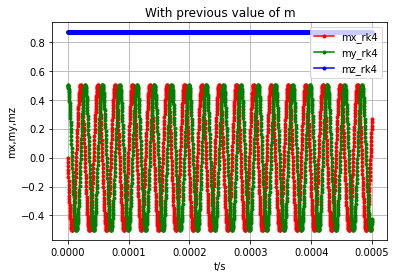

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(t_axis, mx, '.r-', label='mx_rk4')
plt.plot(t_axis, my, '.g-', label='my_rk4')
plt.plot(t_axis, mz, '.b-', label='mz_rk4')

plt.title("With previous value of m")
plt.xlabel("t/s")
plt.ylabel("mx,my,mz")
plt.legend(loc='upper right')
plt.grid()

plt.show()

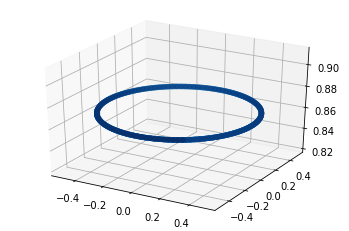

In [30]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# ax.plot3D(mx, my, mz, 'gray')
ax.scatter3D(mx, my, mz, c=t_axis, cmap='Blues');

In [31]:
# mxmy_anal = -(gamma*mu_0)/(1+alpha**2)*t_axis

In [32]:
# ## failed attempt
# mx_anal = -(gamma*mu_0)/(1+alpha**2)*t_axis*my

# my_anal = (gamma*mu_0)/(1+alpha**2)*t_axis*mx


# # my_anal = []
# # for i in range(0,len(t_axis)):
# #     my_anal = -mx[i]*((1+alpha**2)/(gamma*mu_0))/t_axis[i]

In [33]:
mx_anal=[]
my_anal=[]
for i in range(0,len(t_axis)):
    s_y = 1/(-2*(gamma*mu_0)/(1+alpha**2) - 2*math.tan(-(gamma*mu_0)/(1+alpha**2)*H[2]*t_axis[i]))
    my_anal.append(0.5*math.cos(-(gamma*mu_0)/(1+alpha**2)*H[2]*t_axis[i]) + s_y*math.sin(-(gamma*mu_0)/(1+alpha**2)*H[2]*t_axis[i]))
    mx_anal.append(0.5*math.sin(-(gamma*mu_0)/(1+alpha**2)*H[2]*t_axis[i]))

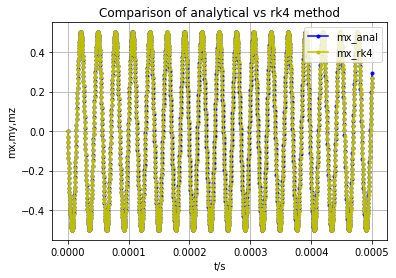

In [34]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plt.plot(t_axis, m_anal, label='Analytical')

plt.plot(t_axis, mx_anal, '.b-', label='mx_anal')
plt.plot(t_axis, mx, '.y-', label='mx_rk4')

plt.title("Comparison of analytical vs rk4 method")
plt.xlabel("t/s")
plt.ylabel("mx,my,mz")
plt.legend(loc='upper right')
plt.grid()

plt.show()

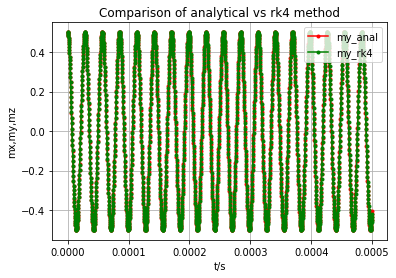

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plt.plot(t_axis, m_anal, label='Analytical')

plt.plot(t_axis, my_anal, '.r-', label='my_anal')
plt.plot(t_axis, my, '.g-', label='my_rk4')

plt.title("Comparison of analytical vs rk4 method")
plt.xlabel("t/s")
plt.ylabel("mx,my,mz")
plt.legend(loc='upper right')
plt.grid()

plt.show()

### Simulating full LLGS

In [99]:
t_range = 2*10**(-8)
t_0 = 0
step_amount = 2001
t_axis = np.linspace(t_0,t_range,step_amount)

h = t_range/step_amount
m_0 = [0, 1/2, math.sqrt(1-(1/2)**2)]
# m_0 = np.array([0,0,-1])

In [100]:
m_rk4 = calcMSeries(t_axis, h, t_0, m_0)

In [101]:
# separate mx my mz
mx = [item[0] for item in m_rk4]
my = [item[1] for item in m_rk4]
mz = [item[2] for item in m_rk4]

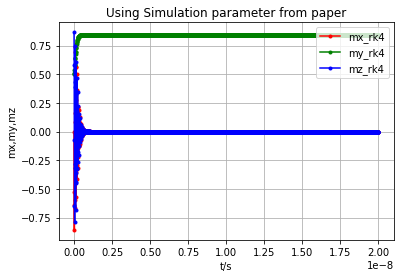

In [102]:
# plot result
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(t_axis, mx, '.r-', label='mx_rk4')
plt.plot(t_axis, my, '.g-', label='my_rk4')
plt.plot(t_axis, mz, '.b-', label='mz_rk4')

plt.title("Using Simulation parameter from paper")
plt.xlabel("t/s")
plt.ylabel("mx,my,mz")
plt.legend(loc='upper right')
plt.grid()

plt.show()

In [103]:
H_eff

array([      0.        , -387175.        ,  -16194.67505077])